In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPooling2D, Reshape, Flatten, Input, merge
from keras import backend as K

Using TensorFlow backend.


In [2]:
data = pd.read_csv("train.csv")

In [3]:
#For now, we remove new_whale
data = data[data['Id'] != 'new_whale']

In [4]:
len(data)

9040

In [5]:
from PIL import Image
image = Image.open('train/0a5c0f48.jpg')

In [6]:
image = image.resize((256,256))

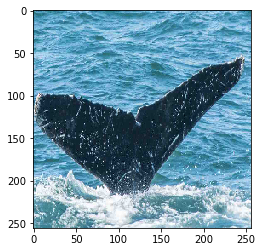

In [7]:
plt.imshow(image)
plt.show()

In [8]:
np.array(image).shape

(256, 256, 3)

It's probably good to resize these images to (256, 256)

Its not sensible to read all the images into memory. So, we will read them in in batches of arbitrary size BATCH_SIZE (8?), and fit to them. Then do the same when predicting. Maybe use model.fit_generator? Generator can load files, preprocess and yield them.

In [9]:
gray = np.mean(image, -1)

In [10]:
gray.shape

(256, 256)

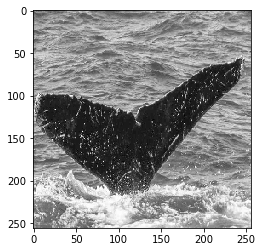

In [11]:
plt.imshow(gray,cmap='gray')
plt.show()

We need a map from a list of filenames and labels to an X, y.

In [12]:
def preprocess(image, size=(256,256)):
    image = image.resize(size)  
    image = np.array(image)
    if len(image.shape) == 3:
        image = np.mean(image, -1) 
    assert image.shape == (256,256)
    return image

def file_to_image(filename):
    raw_image = Image.open('train/' + filename)
    image = preprocess(raw_image)
    del raw_image
    return image

def file_list_to_image_array(file_list):
    return np.stack([file_to_image(f) for f in file_list])

In [13]:
files = data['Image']
y = data['Id']

#Use this to test simple classification
# y = y.map(lambda x: int(x=='new_whale'))

In [14]:
from sklearn.model_selection import train_test_split
files_train, files_test, y_train, y_test = train_test_split(
    files, y, test_size=0.1, random_state=42)

In [15]:
def batch_generator(iterable, batch_size=1):
    while True:
        l = len(iterable)
        for ndx in range(0, l, batch_size):
            yield iterable[ndx:min(ndx + batch_size, l)]

Now need to create the pairs of images inputs.

In [23]:
def get_same_whale_image(x):
    filtered = data[(data['Id'] == x['Id'])]
    return filtered.sample(1).values[0] 

def get_different_whale_image(x):
    filtered = data[(data['Id'] != x['Id'])]
    return filtered.sample(1).values[0]

In [24]:
BINARY_DATASET_SIZE = 10000

SAME_WHALE_DATASET_SIZE = BINARY_DATASET_SIZE // 2
DIFFERENT_WHALE_DATASET_SIZE = BINARY_DATASET_SIZE // 2

In [25]:
same_whale_dataset = data.sample(SAME_WHALE_DATASET_SIZE, replace=True)
same_whale_dataset[['Image2', 'Id2']] = same_whale_dataset.apply(get_same_whale_image, axis=1)
same_whale_dataset.columns = ['Image1', 'Id1','Image2', 'Id2']
same_whale_dataset = same_whale_dataset[same_whale_dataset['Image1'] != same_whale_dataset['Image2']]
same_whale_dataset['target'] = 1

In [26]:
different_whale_dataset = data.sample(DIFFERENT_WHALE_DATASET_SIZE, replace=True)
different_whale_dataset[['Image2', 'Id2']] = different_whale_dataset.apply(get_different_whale_image, axis=1)
different_whale_dataset.columns = ['Image1', 'Id1','Image2', 'Id2']
different_whale_dataset['target'] = 0

In [27]:
binary_dataset = pd.concat([same_whale_dataset, different_whale_dataset]).sample(frac=1)

In [28]:
len(binary_dataset)

7664

In [29]:
def binary_data_generator(batch_size):
    file_1_generator = batch_generator(binary_dataset['Image1'], batch_size)
    file_2_generator = batch_generator(binary_dataset['Image2'], batch_size)
    target_generator = batch_generator(binary_dataset['target'], batch_size)
    
    while True:
        file_1_batch = next(file_1_generator)
        file_2_batch = next(file_2_generator)
        
        image_1_batch = file_list_to_image_array(file_1_batch)
        image_2_batch = file_list_to_image_array(file_2_batch)
        
        pairs = [image_1_batch, image_2_batch]
        targets = next(target_generator)
        
        yield pairs, targets

In [40]:
BATCH_SIZE = 128
siamese_data_generator = binary_data_generator(BATCH_SIZE)

In [41]:
# next(gen)[0][1].shape

This seems to be the correct generator.

# Create the siamese network

In [42]:
input_shape = (256, 256)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'

convnet = Sequential()
convnet.add(Reshape((256, 256, 1,), input_shape=(256,256,),name='Reshape'))
convnet.add(Conv2D(filters=8, input_shape=(256,256,1,), kernel_size=3, activation='relu',name='conv_1'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_1'))
convnet.add(Conv2D(filters=16, kernel_size=3, activation='relu',name='conv_2'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_2'))
convnet.add(Conv2D(filters=32, kernel_size=3, activation='relu',name='conv_3'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_3'))
convnet.add(Flatten())
convnet.add(Dense(units=1024, activation='relu',name='dense_1'))

#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid')(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)
optimizer=Adam(0.00001)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])


/home/edward/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/edward/miniconda3/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/edward/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [46]:
print("Baseline accuracy: ",1 - np.mean(binary_dataset['target']))

Baseline accuracy:  0.652400835073


In [ ]:
history = siamese_net.fit_generator(siamese_data_generator, verbose=1, epochs = 100, steps_per_epoch=len(binary_dataset)//BATCH_SIZE)

Epoch 1/100
59/59 [==============================] - 431s 7s/step - loss: 1.0850 - acc: 0.6442
Epoch 2/100
31/59 [==============>...............] - ETA: 3:19 - loss: 0.6476 - acc: 0.7258